# Module

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import netCDF4
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
import shutil
from scipy.spatial import distance
import metpy
import xskillscore as xs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.feature import NaturalEarthFeature
from glob import *
import sys, os, time, warnings
import pandas as pd
import pytz
from glob import *
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from dask.diagnostics import ProgressBar
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')
import iris

### grid inverse function

In [2]:
def grid_transfer(data):
    data=data.sortby(data['latitude'], ascending=True) #위도 ㅂ반전
    data['longitude'] = xr.where(data['longitude'] > 180, data['longitude'] - 360, data['longitude']) # 경도 반전
    data = data.sortby(data['longitude']) #바뀐 경도에 대해 값들 맞춰줌 한번만 실행할것
    
    return data

### grid same

In [3]:
import xesmf as xe

In [4]:
def regrid(change_data,target_data):
    grid_frame = xe.Regridder(change_data, target_data, "bilinear")
    regrid_data=grid_frame(change_data)
    return regrid_data

# Data load

In [5]:
ERA5path='/data1/ERA5/hourly/land/'

In [6]:
ERA_list=sorted(glob(ERA5path+'*.nc'))

##### swvl1,mtpr,t2m,d2m,sp
----- calculate ----
Compute the Specific Humidity (Bolton 1980):  
e = 6.112exp((17.67Td)/(Td + 243.5));  
q = (0.622 * e)/(p - (0.378 * e));  

where:  
e = vapor pressure in mb;  
Td = dew point in deg C;  
p = surface pressure in mb;  
q = specific humidity in kg/kg.  
  
(Note the final specific humidity units are in g/kg = (kg/kg)*1000.0)

# ERA5

In [7]:
with ProgressBar():
    ERA = xr.open_mfdataset(ERA_list)[['swvl1','mtpr','t2m','d2m','sp']]
    ERA

In [8]:
ERA['mtpr'] = ERA['mtpr']*60*60*3

In [9]:
ERA_resample=ERA.resample(time='1M').mean('time')

In [10]:
ERA_resample=ERA_resample.sortby('time').sel(time=slice('2013-01-31T00:00:00.000000000','2022-12-31T00:00:00.000000000'))

In [11]:
tpr = ERA['mtpr'].resample(time='1M').sum('time')

In [12]:
ERA_resample['mtpr']=tpr.sortby('time').sel(time=slice('2013-01-31T00:00:00.000000000','2022-12-31T00:00:00.000000000'))

In [13]:
del (tpr)

In [14]:
ERA_resample['mtpr']=ERA_resample['mtpr'].assign_attrs(units="mm/month", long_name="Total accumulate precipitation")
ERA_resample=ERA_resample.assign_attrs(Source = 'ERA5')

In [15]:
del (ERA)

In [16]:
ERA_resample

<xarray.Dataset>
Dimensions:    (time: 120, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2022-12-31
Data variables:
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    mtpr       (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-03 22:23:52 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
    Source:       ERA5

In [33]:
# -180~180
# -90~90으로 바꿔주는 부분

import xarray as xr
import numpy as np

longitude = np.arange(-177.5, 180.+2.5, 2.5)
latitude = np.arange(-87.5, 90.+2.5, 2.5)

ERA_regrid = xr.Dataset(
    {
        'latitude': (['latitude'], latitude),'longitude': (['longitude'], longitude)
    }
)
ERA_regrid['test'] = xr.DataArray(np.zeros((len(latitude), len(longitude))), dims=['latitude', 'longitude'])

In [80]:
test = regrid(ERA_resample,ERA_regrid)

In [42]:
test = ERA_resample

In [44]:
test['swvl1']=test['swvl1'].assign_attrs(units = 'm**3 m**-3', long_name ='Volumetric soil water layer 1')
test['mtpr']=test['mtpr'].assign_attrs(units = 'mm/month', long_name ='Total accumulate precipitation')
test['t2m']=test['t2m'].assign_attrs(units = 'K', long_name ='2 metre temperature')
test['d2m']=test['d2m'].assign_attrs(units = 'K', long_name ='2 metre dewpoint temperature')
test['sp']=test['sp'].assign_attrs(units = 'Pa', long_name ='Surface pressure')

In [93]:
with ProgressBar():
    test.load()

[                                        ] | 0% Completed | 63.65 sms

KeyboardInterrupt: 

In [22]:
with ProgressBar():
    ERA_resample.load().to_netcdf('/home/gychoi/Python/Lab/output_file/중요/ERA5.nc')

[########################################] | 100% Completed | 21m 5ss


In [28]:
ERA_resample = xr.open_dataset('/home/gychoi/Python/Lab/output_file/중요/ERA5.nc')

In [ ]:
regrid()

In [35]:
ERA_resample=regrid(ERA_resample,ERA_regrid)

In [38]:
with ProgressBar():
    ERA_resample.load()

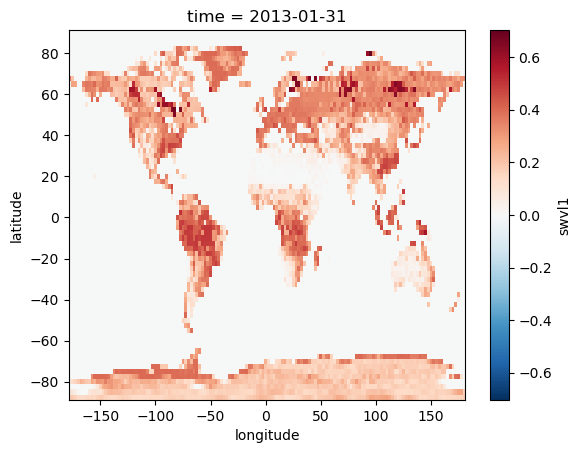

In [43]:
test['swvl1'][0].plot()

In [45]:
test

<xarray.Dataset>
Dimensions:    (time: 120, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2022-12-31
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    swvl1      (time, latitude, longitude) float32 0.1773 0.1816 ... -2.478e-07
    mtpr       (time, latitude, longitude) float32 16.35 17.15 ... 51.53 51.53
    t2m        (time, latitude, longitude) float32 247.9 248.0 ... 249.8 249.8
    d2m        (time, latitude, longitude) float32 244.3 244.4 ... 247.0 247.0
    sp         (time, latitude, longitude) float32 6.722e+04 ... 1.023e+05
Attributes:
    regrid_method:  bilinear

In [46]:
with ProgressBar():
    test.load().to_netcdf('/home/gychoi/Python/Lab/output_file/중요/ERA5_class.nc')

# KIM

1. monthly
2. dirunal cycle

In [39]:
data_folder = '/data1/KIM/netcdf/'

In [40]:
data_folder

'/data1/KIM/netcdf/'

## tpr

In [7]:
import glob

subdirectories = ["202106", "202107", "202108","202206", "202207", "202208"]

file_list = []
for i in range (len(subdirectories)):
    A = sorted(glob.glob(data_folder +subdirectories[i]+ "/*"+'/tpr*'+'*3hr.nc4', recursive=True))
    file_list = file_list+A

In [8]:
file = []
for i in range (len(file_list)):
    file.append(xr.open_dataset(file_list[i],chunks={ 'latitude':'auto','longitude':'auto','time': 1}).isel(time=slice(1, None)).drop('reference_time')) #chunks={ 'latitude':360,'longitude':576,'time': 1}

In [9]:
with ProgressBar():
    KIM=xr.concat(file ,'data')

In [10]:
del (file,file_list)

In [11]:
del (A)

from tqdm.autonotebook import tqdm

pbar = tqdm(total=len(file))

for i in range (len(file)):
    file[i] = regrid(file[i],era5)
    pbar.update(1)
pbar.close()

In [12]:
with ProgressBar():
    KIM=KIM.mean('data')
    KIM=KIM.sortby('time')

In [13]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1576, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-09-07T12:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    tpr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [14]:
KIM=KIM.sel(time=((KIM['time.month'] >= 6) & (KIM['time.month'] <= 8)))

In [15]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1470, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-08-31T21:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    tpr        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [16]:
with ProgressBar():
    KIM.to_netcdf('/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_tpr.nc')

[########################################] | 100% Completed | 10m 49s


## sm1

In [41]:
import glob

subdirectories = ["202106", "202107", "202108","202206", "202207", "202208"]

file_list = []
for i in range (len(subdirectories)):
    A = sorted(glob.glob(data_folder +subdirectories[i]+ "/*"+'/sm1*'+'*3hr.nc4', recursive=True))
    file_list = file_list+A

In [48]:
file = []
for i in range (len(file_list)):
    file.append(xr.open_dataset(file_list[i],chunks={ 'latitude':'auto','longitude':'auto','time': 1}).isel(time=slice(1, None)).drop('reference_time')) #chunks={ 'latitude':360,'longitude':576,'time': 1}

In [49]:
with ProgressBar():
    KIM=xr.concat(file ,'data')

In [50]:
del (file,file_list)

In [51]:
del (A)

from tqdm.autonotebook import tqdm

pbar = tqdm(total=len(file))

for i in range (len(file)):
    file[i] = regrid(file[i],era5)
    pbar.update(1)
pbar.close()

In [52]:
with ProgressBar():
    KIM=KIM.mean('data')
    KIM=KIM.sortby('time')

In [53]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1576, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-09-07T12:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    sm1        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [54]:
KIM=KIM.sel(time=((KIM['time.month'] >= 6) & (KIM['time.month'] <= 8)))

In [55]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1470, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-08-31T21:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    sm1        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [56]:
with ProgressBar():
    KIM.to_netcdf('/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_sm1.nc')

[########################################] | 100% Completed | 12m 23s


## t2m

In [27]:
import glob

subdirectories = ["202106", "202107", "202108","202206", "202207", "202208"]

file_list = []
for i in range (len(subdirectories)):
    A = sorted(glob.glob(data_folder +subdirectories[i]+ "/*"+'/t2m_*'+'*3hr.nc4', recursive=True))
    file_list = file_list+A

In [28]:
file = []
for i in range (len(file_list)):
    file.append(xr.open_dataset(file_list[i],chunks={ 'latitude':'auto','longitude':'auto','time': 1}).isel(time=slice(1, None)).drop('reference_time')) #chunks={ 'latitude':360,'longitude':576,'time': 1}

In [29]:
with ProgressBar():
    KIM=xr.concat(file ,'data')

In [30]:
del (file,file_list)

In [31]:
del (A)

from tqdm.autonotebook import tqdm

pbar = tqdm(total=len(file))

for i in range (len(file)):
    file[i] = regrid(file[i],era5)
    pbar.update(1)
pbar.close()

In [32]:
with ProgressBar():
    KIM=KIM.mean('data')
    KIM=KIM.sortby('time')

In [33]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1576, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-09-07T12:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    t2m        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [34]:
KIM=KIM.sel(time=((KIM['time.month'] >= 6) & (KIM['time.month'] <= 8)))

In [35]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1470, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-08-31T21:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    t2m        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [36]:
with ProgressBar():
    KIM.to_netcdf('/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_t2m.nc')

[########################################] | 100% Completed | 10m 56s


## q2m

In [57]:
import glob

subdirectories = ["202106", "202107", "202108","202206", "202207", "202208"]

file_list = []
for i in range (len(subdirectories)):
    A = sorted(glob.glob(data_folder +subdirectories[i]+ "/*"+'/q2m_*'+'*3hr.nc4', recursive=True))
    file_list = file_list+A

In [58]:
file = []
for i in range (len(file_list)):
    file.append(xr.open_dataset(file_list[i],chunks={ 'latitude':'auto','longitude':'auto','time': 1}).isel(time=slice(1, None)).drop('reference_time')) #chunks={ 'latitude':360,'longitude':576,'time': 1}

In [59]:
with ProgressBar():
    KIM=xr.concat(file ,'data')

In [60]:
del (file,file_list)

In [61]:
del (A)

from tqdm.autonotebook import tqdm

pbar = tqdm(total=len(file))

for i in range (len(file)):
    file[i] = regrid(file[i],era5)
    pbar.update(1)
pbar.close()

In [62]:
with ProgressBar():
    KIM=KIM.mean('data')
    KIM=KIM.sortby('time')

In [63]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1576, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-09-07T12:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    q2m        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [64]:
KIM=KIM.sel(time=((KIM['time.month'] >= 6) & (KIM['time.month'] <= 8)))

In [65]:
KIM

<xarray.Dataset>
Dimensions:    (time: 1470, latitude: 72, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-08-31T21:00:00
  * latitude   (latitude) float64 -87.5 -85.0 -82.5 -80.0 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    q2m        (time, latitude, longitude) float64 dask.array<chunksize=(1, 72, 144), meta=np.ndarray>

In [66]:
with ProgressBar():
    KIM.to_netcdf('/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_q2m.nc')

[########################################] | 100% Completed | 11m 38s


## 만든 자료 불러오기

In [153]:
file = ['/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_tpr.nc'
        ,'/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_q2m.nc'
        ,'/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_t2m.nc'
        ,'/data1/user/gychoi/Data/KIM2.5/KIM_daily_jja_sm1.nc']

In [154]:
KIM = xr.open_mfdataset(file)

In [155]:
KIM=KIM.sel(latitude = slice(-60,80))

In [156]:
KIM['sm1'] = xr.where(KIM['sm1'] >= 8000., np.nan,KIM['sm1'] )

In [64]:
KIM['tpr'] = KIM['tpr'].where(KIM['tpr'] >= 0.1)

## 3시간으로 바꿔주는

In [158]:
ERA = xr.open_dataset('/data1/user/gychoi/Data/class/ERA5_class_monthly.nc')

In [162]:
KIM
KIM['q2m']=KIM['q2m'].assign_attrs({'units': 'kg/kg', 'long_name': '2 metre specific humidity'})
KIM['t2m']=KIM['t2m'].assign_attrs({'units': 'K', 'long_name': '2 metre temperature'})
KIM['sm1']=KIM['sm1'].assign_attrs({'units': 'm**3 m**-3', 'long_name': 'Volumetric soil water layer 1'})
KIM['tpr']=KIM['tpr'].assign_attrs({'units': 'mm/3h', 'long_name': 'Total accumulate precipitation'})

In [65]:
KIM=KIM.groupby('time.hour').mean('time')

In [152]:
KIM.to_netcdf('/data1/user/gychoi/Data/class/KIM_class_diurnal.nc')

In [164]:
KIM.to_netcdf('/data1/user/gychoi/Data/class/KIM_class_3hourly.nc')

In [175]:
KIM.to_netcdf('/data1/user/gychoi/Data/class/KIM_class_daily.nc')

## 그림 시험

In [178]:
A=KIM['q2m'].hvplot.image(x='longitude',y='latitude',coastline=True)
A.redim.range(value=(0, 0.01))

:DynamicMap   [time]
   :Overlay
      .Image.I     :Image   [longitude,latitude]   (q2m)
      .Coastline.I :Feature   [Longitude,Latitude]

In [96]:
import hvplot.xarray

In [97]:
corr_tpr_sm=xr.corr(KIM['tpr'],KIM['sm1'],'hour')
corr_tpr_sm.hvplot.image(title=r'R(tpr,SM)',coastline=True)

:Overlay
   .Image.I     :Image   [longitude,latitude]   (value)
   .Coastline.I :Feature   [Longitude,Latitude]

In [98]:
xr.corr(KIM['q2m'],KIM['sm1'],'hour')
corr_q2m_sm.hvplot.image(title=r'R(q2m,SM)',coastline=True)

:Overlay
   .Image.I     :Image   [longitude,latitude]   (value)
   .Coastline.I :Feature   [Longitude,Latitude]

In [102]:
corr_t2m_sm=xr.corr(KIM['t2m'],KIM['sm1'],'hour')
A=corr_t2m_sm.hvplot.image(title=r'R(T2m,SM)',coastline=True,cmap="RdBu")
A.redim.range(value=(-1, 1))

:Overlay
   .Image.I     :Image   [longitude,latitude]   (value)
   .Coastline.I :Feature   [Longitude,Latitude]

In [104]:
corr_t2m_sm=xr.corr(KIM['t2m'],KIM['sm1'],'hour')
corr_t2m_sm.hvplot.image(title=r'R(T2m,SM)',coastline=True,cmap="RdBu")

:Overlay
   .Image.I     :Image   [longitude,latitude]   (value)
   .Coastline.I :Feature   [Longitude,Latitude]

### 불러와서 비교하기

In [182]:
xr.open_dataset('/data1/user/gychoi/Data/class/KIM_class_diurnal.nc')

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 144, hour: 8)
Coordinates:
  * latitude   (latitude) float64 -60.0 -57.5 -55.0 -52.5 ... 75.0 77.5 80.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
  * hour       (hour) int64 0 3 6 9 12 15 18 21
Data variables:
    q2m        (hour, latitude, longitude) float64 ...
    sm1        (hour, latitude, longitude) float64 ...
    t2m        (hour, latitude, longitude) float64 ...
    tpr        (hour, latitude, longitude) float64 ...

In [183]:
xr.open_dataset('/data1/user/gychoi/Data/class/KIM_class_3hourly.nc')

<xarray.Dataset>
Dimensions:    (time: 1470, latitude: 57, longitude: 144)
Coordinates:
  * time       (time) datetime64[ns] 2021-06-01T03:00:00 ... 2022-08-31T21:00:00
  * latitude   (latitude) float64 -60.0 -57.5 -55.0 -52.5 ... 75.0 77.5 80.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
Data variables:
    q2m        (time, latitude, longitude) float64 ...
    sm1        (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
    tpr        (time, latitude, longitude) float64 ...

In [184]:
xr.open_dataset('/data1/user/gychoi/Data/class/KIM_class_daily.nc')

<xarray.Dataset>
Dimensions:    (latitude: 57, longitude: 144, time: 457)
Coordinates:
  * latitude   (latitude) float64 -60.0 -57.5 -55.0 -52.5 ... 75.0 77.5 80.0
  * longitude  (longitude) float64 -177.5 -175.0 -172.5 ... 175.0 177.5 180.0
  * time       (time) datetime64[ns] 2021-06-01 2021-06-02 ... 2022-08-31
Data variables:
    q2m        (time, latitude, longitude) float64 ...
    sm1        (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
    tpr        (time, latitude, longitude) float64 ...